In [293]:
import numpy as np 
from matplotlib import pyplot as plt
import random
from scipy import interpolate
import time
from scipy import interpolate, integrate

In [271]:
Ttot = 200 # days
t = np.linspace(0,Ttot,Ttot+1) #days
mean = 0
std = 1

In [275]:
# Create distribution of the max amplitude
Nb = 50000
tfs = np.zeros((Nb,int(t.shape[0]/2)))
amp_max = np.zeros(Nb)

for i in range(Nb):
    y = np.random.normal(mean, std, size = t.shape[0])
    tfs[i,:] = np.abs(np.fft.fft(y))[0:int(t.shape[0]/2)]
    amp_max[i] = max(tfs[i,:])

pdf_max = np.histogram(amp_max, bins = 50, density = True)

Text(0, 0.5, 'Density')

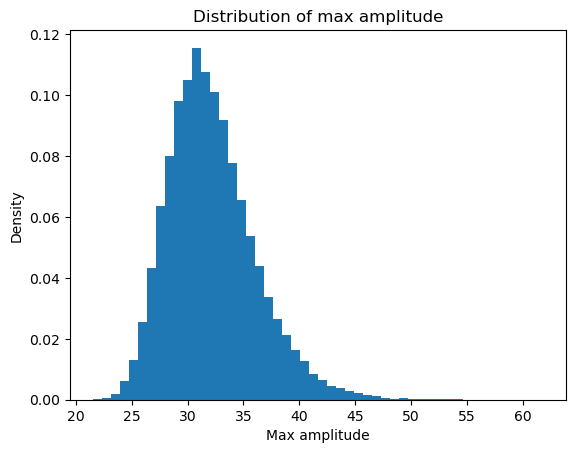

In [276]:
plt.title("Distribution of max amplitude")
plt.bar(pdf_max[1][:-1], pdf_max[0], width=np.diff(pdf_max[1]), align='edge')
plt.xlabel("Max amplitude")
plt.ylabel("Density")

In [277]:
# Create distrubtuion for the amplitude for each frequency 
pdfs = []
for k in range(tfs.shape[1]):
    pdfs.append(np.histogram(tfs[:,k], bins = 50, density = True))

Text(0, 0.5, 'Density')

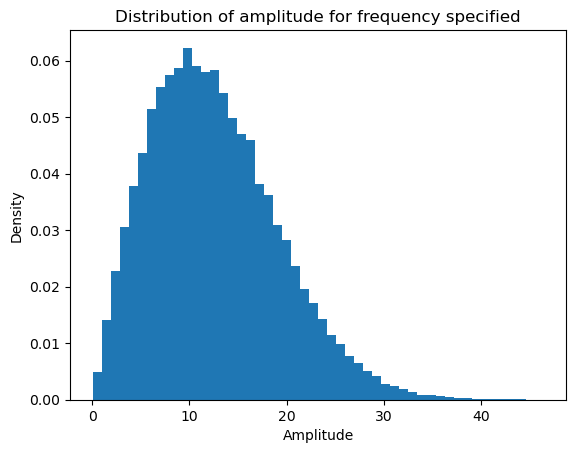

In [283]:
ind = 5
plt.title("Distribution of amplitude for frequency specified")
plt.bar(pdfs[ind][1][:-1], pdfs[ind][0], width=np.diff(pdfs[ind][1]), align='edge')
plt.xlabel("Amplitude")
plt.ylabel("Density")

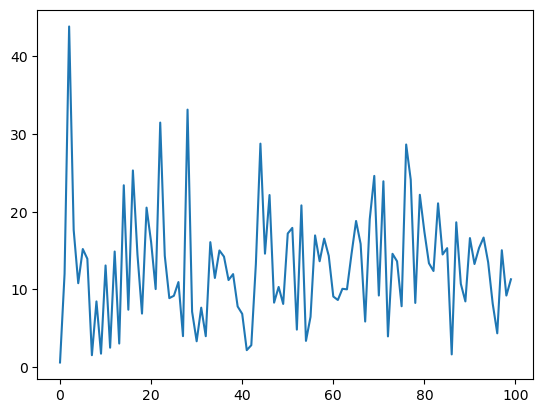

In [284]:
K = random.uniform(0.1,1)
Ppl = random.uniform(5,100)
T0 = random.uniform(0,Ppl)
y_pl = np.random.normal(mean, std, size = t.shape[0]) + K*np.sin(2*np.pi*(t-T0)/Ppl)
plt.plot(np.abs(np.fft.fft(y_pl)[0:int(t.shape[0]/2)]))

In [285]:
# Create testing set
Ntest = 10000
X_test = np.zeros(( Ntest, int(t.shape[0]/2))) # spectre de la TF
Max_test = np.zeros(Ntest) # Max de chaque spectre
Label = np.zeros(Ntest)

for k in range(int(Ntest/2)):
    y = np.random.normal(mean, std, size = t.shape[0])
    X_test[k,:] = np.abs(np.fft.fft(y)[0:int(t.shape[0]/2)])
    Max_test[k] = max(X_test[k,:])
    Label[k] = 0
    
for j in range(int(Ntest/2)):
    K = random.uniform(0.1,1)
    Ppl = random.uniform(5,100)
    T0 = random.uniform(0,Ppl)
    y = np.random.normal(mean, std, size = t.shape[0]) + K*np.sin(2*np.pi*(t-T0)/Ppl)
    X_test[k+j+1,:] = np.abs(np.fft.fft(y)[0:int(t.shape[0]/2)])
    Max_test[k+j+1] = max(X_test[k+j+1,:])
    Label[k+j+1] = 1

In [286]:
# Evaluation of the method
def evaluate(y_pred, label): 

    index_n = np.where(label == 0)[0]
    index_p = np.where(label == 1)[0]

    true_positif = (y_pred[index_p] == 1).sum()
    false_positif = (y_pred[index_n] == 1).sum()

    true_negatif = (y_pred[index_n] == 0).sum()
    false_negatif = (y_pred[index_p] == 0).sum()

    m = np.array([
        [true_negatif, false_positif],
        [false_negatif, true_positif]
    ])
    
    eps = 0.00001
    precision = true_positif/(true_positif + false_positif + eps )
    recall = true_positif/(true_positif + false_negatif + eps )
    f_score = (2*precision*recall)/(precision+recall + eps )
    
    return precision, recall,f_score, m

In [287]:
# Function to compute the p-value of a distribution
def compute_p_value( pdf, xi):
    cdf = np.cumsum(pdf[0]*np.diff(pdf[1]))
    mean_bin = np.zeros(pdf[1].shape[0]-1)
    for i in range(pdf[1].shape[0]-1) : mean_bin[i] = (pdf[1][i+1] + pdf[1][i])/2
    f_cdf = interpolate.interp1d(mean_bin, cdf,bounds_error = False, fill_value = (0,1))
    p_value = 1 - f_cdf(xi)
    return p_value

In [288]:
# Predict label with max distribution method
def predict_FAP(Maxs, pdf_mean):
    N_test = Maxs.shape[0]
    p_vals = np.zeros(N_test)
    for i in range(N_test):
        p_vals[i] = compute_p_value(pdf_mean,Maxs[i])
    return p_vals

In [289]:
# Predict label with distribution for each frequency
def predict_pval(GLS, pdfs):
    N_test = GLS.shape[0]
    p_vals = np.zeros(N_test)
    ind = np.zeros(N_test)
    
    for i in range(N_test):
        p_val_min = 100
        for k in range(len(pdfs)):
            p_val = compute_p_value(pdfs[k],GLS[i][k])
            if (p_val < p_val_min ) : p_val_min, indice = p_val, k
        
        ind[i] = indice
        p_vals[i] = p_val_min
    return p_vals

In [290]:
y_pvals_max = predict_FAP(Max_test, pdf_max)

In [291]:
y_pvals_f = predict_pval(X_test, pdfs)

/tmp/ipykernel_27041/3228888623.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  auc1 = integrate.quad(f1, 0, 1)
/tmp/ipykernel_27041/3228888623.py:33: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose i

Text(0, 0.5, 'PDET')

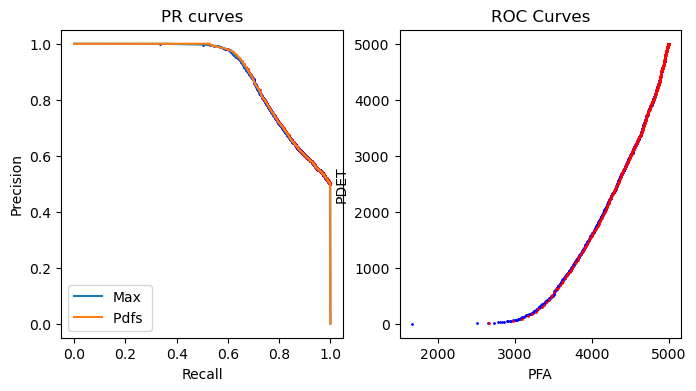

In [316]:
N = 1000
threshold1 = np.linspace(0.00001,max(y_pvals_max),N)
threshold2 = np.linspace(0.00001,max(y_pvals_f),N)

P1, R1 = np.zeros(N), np.zeros(N)
Pdet1, Pfa1 = np.zeros(N), np.zeros(N)

P2, R2 = np.zeros(N), np.zeros(N)
Pdet2, Pfa2 = np.zeros(N), np.zeros(N)

best_score_max = 0
best_score_pdfs = 0

for i in range(N):
    y_seuil = np.where(y_pvals_max < threshold1[i],1,0)
    P1[i] ,R1[i],f,m = evaluate(y_seuil,Label)
    Pdet1[i] = m[1,1]
    Pfa1[i] = m[0,1]
    if (f > best_score_max) : best_score_max, best_threshold_max, best_m_max = f, threshold[i], m
         
    y_seuil = np.where(y_pvals_f < threshold2[i],1,0)
    P2[i] ,R2[i],f,m = evaluate(y_seuil,Label)
    Pdet2[i] = m[1,1]
    Pfa2[i] = m[0,1]
    if (f > best_score_pdfs) : best_score_pdfs, best_threshold_pdfs, best_m_pdfs = f, threshold[i], m 
        
        
x_interp = np.linspace(0,1,N)
f1 = interpolate.interp1d(R1, P1,bounds_error = False, fill_value = (1,0))
f2 = interpolate.interp1d(R2, P2,bounds_error = False, fill_value = (1,0))

auc1 = integrate.quad(f1, 0, 1)
auc2 = integrate.quad(f2, 0, 1)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("PR curves")
plt.scatter(R1,P1, s = 1, c ='b')
plt.plot(x_interp,f1(x_interp),label='Max'),plt.legend()
plt.scatter(R2,P2,s = 1, c ='r'), 
plt.plot(x_interp,f2(x_interp),label='Pdfs '),plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.subplot(122)
plt.title("ROC Curves")
plt.scatter(Pdet1,Pfa1, s = 1, c ='b')
plt.scatter(Pdet2,Pfa2,s = 1, c ='r')
plt.xlabel("PFA")
plt.ylabel("PDET")

In [225]:
Label.shape

(10000,)

In [214]:
index_n = np.where(Label == 0)[0]
index_p = np.where(Label == 1)[0]

In [215]:
index_p

array([5000, 5001, 5002, ..., 9997, 9998, 9999])

In [218]:
y_seuil = np.where(y_pvals_max > 0.01,1,0)
print(y_seuil[index_p])

[0 0 0 ... 1 0 1]


In [246]:
X_test.shape

(100, 10000)

In [227]:
y_seuil = np.where( y_pvals_f > 0.01, 1,0)
index_n = np.where(label == 0)[0]
index_p = np.where(label == 1)[0]

true_positif = (y_pred[index_p] == 1).sum()
false_positif = (y_pred[index_n] == 1).sum()

true_negatif = (y_pred[index_n] == 0).sum()
false_negatif = (y_pred[index_p] == 0).sum()

TypeError: '>' not supported between instances of 'tuple' and 'float'

In [240]:
y_pvals_f.shape

(100,)

In [239]:
len(pdfs)

201

In [244]:
pdf[0]

array([1.27621325e-04, 1.70161766e-04, 2.12702208e-04, 7.23187507e-04,
       1.36129413e-03, 2.68004782e-03, 3.99880151e-03, 8.55062876e-03,
       1.11030553e-02, 1.92708200e-02, 2.73960444e-02, 3.73930482e-02,
       4.49227063e-02, 5.77699197e-02, 6.92132985e-02, 8.35494273e-02,
       9.19298943e-02, 9.78004752e-02, 1.01076089e-01, 1.08818450e-01,
       1.14731571e-01, 1.08818450e-01, 1.10349905e-01, 1.04606946e-01,
       1.02735166e-01, 9.08663832e-02, 8.75907692e-02, 7.69131184e-02,
       7.58070669e-02, 6.47465521e-02, 5.78550006e-02, 5.07507468e-02,
       4.76027541e-02, 3.84565592e-02, 3.33091658e-02, 2.88424194e-02,
       2.68004782e-02, 2.11851399e-02, 1.93559009e-02, 1.43786693e-02,
       1.28472134e-02, 1.25068898e-02, 9.14619494e-03, 7.40203684e-03,
       5.65787873e-03, 5.91312138e-03, 4.59436769e-03, 4.21150372e-03,
       3.48831621e-03, 2.97783091e-03, 2.21210296e-03, 2.25464340e-03,
       1.91431987e-03, 1.02097060e-03, 9.35889715e-04, 1.14859192e-03,
      

In [305]:
min(y_pvals_f)

0.0

In [306]:
min(y_pvals_max)

0.0